In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import ElementsEnv
from scipy import signal
from astropy.table import Table

%erun Elements 6.0.1

os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/auxdir/'

sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/python/')

%load_ext autoreload
%autoreload 2

from nnpz.photometry.filter_provider import DirectoryFilterProvider
from nnpz.photometry.calculator.photometry_calculator import PhotometryCalculator
from nnpz.photometry.calculator.fnu_ujy_processor import FnuuJyPrePostProcessor
from nnpz.reference_sample.ReferenceSample import ReferenceSample

In [2]:
nnpz_photo = Table.read('/tmp/nnpz_corr.fits', hdu=1)
phos_photo = Table.read('/tmp/phosphoros_corr.fits', hdu=1)

In [3]:
ref_sample = ReferenceSample('/home/aalvarez/Work/Data/SC8/PHZ_Prod_18oct2021/ProductionInputEcdmHandler/reference_sample_dir.dir/')

INFO    : Found provider PdzProvider
2022-03-31T16:32:07CEST ReferenceSample  INFO : Found provider PdzProvider
INFO    : Found provider SedProvider
2022-03-31T16:32:08CEST ReferenceSample  INFO : Found provider SedProvider


In [4]:
f99 = np.loadtxt('/home/aalvarez/Phosphoros/AuxiliaryData/ReddeningCurves/F99_3.1.dat')

In [5]:
filters_provider = DirectoryFilterProvider('/home/aalvarez/Phosphoros/AuxiliaryData/Filters/')

In [18]:
shifts = np.linspace(-100, 100, 200)

In [6]:
filter_map = {}
filter_map_shifted = {s: dict() for s in [-100, -50, -25, 25, 50, 100]}
filter_names = filters_provider.get_filter_names()


for filter_name in filter_names:
    filter_map[filter_name] = filters_provider.get_filter_transmission(filter_name)
    filter_map_shifted[filter_name] = []
    for s in [-100, -50, -25, 25, 50, 100]:
        x = np.copy(filter_map[filter_name])
        x[:,0] += s
        filter_map_shifted[s][filter_name] = x

In [17]:
idx = np.random.choice(len(nnpz_photo))

sid = nnpz_photo['ID'][idx]
sed = ref_sample.get_sed_data(sid)
assert(sed is not None)

In [19]:
prepost = FnuuJyPrePostProcessor(filter_map)
calculator = PhotometryCalculator(filter_map, prepost)

prepost_shifted = []
calculator_shifted = []
for s in [-100, -50, -25, 25, 50, 100]:
    prepost_shifted.append(FnuuJyPrePostProcessor(filter_map_shifted[s]))
    calculator_shifted.append(PhotometryCalculator(filter_map_shifted[s], prepost_shifted[-1]))

# Cross check

In [20]:
dphoto = calculator.compute(sed)
sphoto = []
for i, s in enumerate([-100, -50, -25, 25, 50, 100]):
    sphoto.append(calculator_shifted[i].compute(sed))

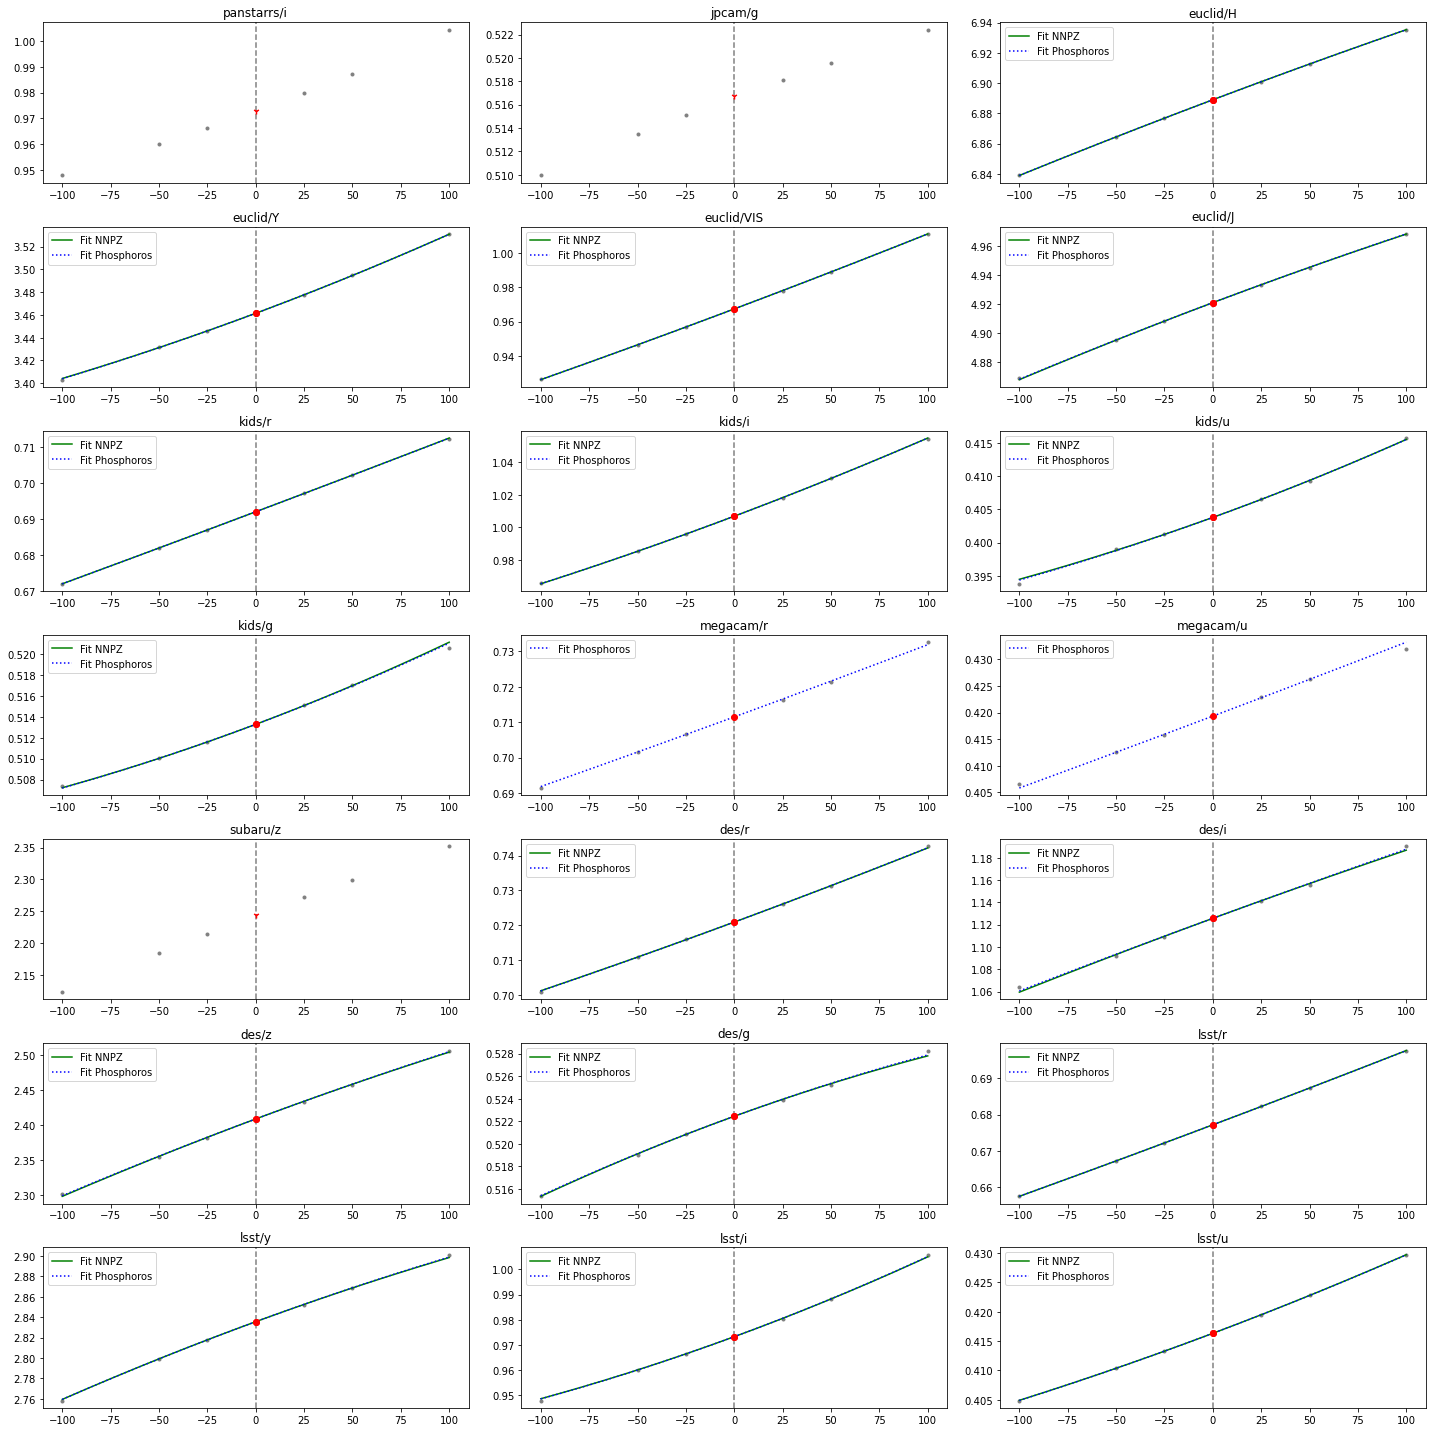

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=len(filter_map)//3, figsize=(20, 20))

for i, ax in enumerate(axes.ravel()):
    fname = filter_names[i]

    ax.set_title(fname)
    ax.axvline(0, linestyle='--', color='gray')
    ax.scatter([-100, -50, -25, 25, 50, 100], [p[fname][0] for p in sphoto], marker='.', zorder=-10, color='gray')
    
    corr_name = f'{fname}_SHIFT_CORR'
    if corr_name in nnpz_photo.columns:
        a, b = nnpz_photo[corr_name][idx]
        ax.plot(shifts, nnpz_photo[fname][idx]*(a * shifts**2 + b * shifts + 1), color='green', label='Fit NNPZ')
        ax.scatter([0], nnpz_photo[fname][idx], marker='o', color='red', zorder=5)
        
    if corr_name in phos_photo.columns:
        a, b = phos_photo[corr_name][idx]
        ax.plot(shifts, phos_photo[fname][idx]*(a * shifts**2 + b * shifts + 1), color='blue', label='Fit Phosphoros', linestyle=':')
        ax.scatter([0], phos_photo[fname][idx], marker='o', color='red', zorder=5)
        ax.legend()
        
    ax.scatter([0], dphoto[fname][0:1], marker='1', color='red', zorder=10)
    
plt.tight_layout()